***Key: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up***

***Load and prepare data:***

In [471]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import scipy.stats as ss

import warnings
warnings.filterwarnings("ignore")

def clean(file):
    file = file.lower()
    skips = [".", ",", ";", ":", "'", '"', "\n", "!", "?", "(", ")"]
    for ch in skips:
        file = file.replace(ch, "")
    return file

def count_words_fast(text):
    text = text.lower()
    skips = [".", ",", ";", ":", "'", '"', "\n", "!", "?", "(", ")"]
    for ch in skips:
        text = text.replace(ch, "")
    word_counts = Counter(text.split(" "))
    return word_counts

def word_stats(word_counts):
    num_unique = len(word_counts)
    counts = word_counts.values()
    return (num_unique, counts)

def majority_vote(votes):
    vote_counts = {}
    for vote in votes:
        if vote in vote_counts:
            vote_counts[vote] += 1
        else:
            vote_counts[vote] = 1
    winners = []
    max_count = max(vote_counts.values())
    for vote, count in vote_counts.items():
        if count == max_count:
            winners.append(vote)
    return random.choice(winners)

def majority_vote_short(votes):
    vote, count = ss.mstats.mode(votes)
    return mode


In [495]:
# Load and read training csv file
file = pd.read_csv("train_time_series.csv")
df = file[['timestamp', 'x', 'y', 'z']].copy()
df.head()

,timestamp,x,y,z
0,1565109930787,-0.006485,-0.934860,-0.069046
1,1565109930887,-0.066467,-1.015442,0.089554
2,1565109930987,-0.043488,-1.021255,0.178467
3,1565109931087,-0.053802,-0.987701,0.068985
4,1565109931188,-0.054031,-1.003616,0.126450


In [496]:
# Load and read label csv file
file2 = pd.read_csv("train_labels.csv")
label_df = file2[['label']].copy()
label_df.head()

,label
0,1
1,1
2,1
3,1
4,1


In [497]:
# Extract every ten entries from training csv file
# Confirm that it matches the length of labels
raw_data = df.to_numpy();
input = []
i = 3
while i < 3744:
    input.append(raw_data[i])
    i += 10

print(len(input))

375


In [498]:
# Turn extracted entries into a dataframe
input_df = pd.DataFrame(input, columns = ['timestamp', 'x', 'y', 'z'])

In [499]:
# Check lengths of the original dataframe and the label dataframe
print (len(df), len(label_df))

3744 375


In [500]:
# Print a portion of the original dataframe
df.tail()

,timestamp,x,y,z
3739,1565110305638,0.024384,-0.710709,0.030304
3740,1565110305738,0.487228,-1.099136,-0.015213
3741,1565110305838,0.369446,-0.968506,0.036713
3742,1565110305939,0.167877,-0.802826,0.049805
3743,1565110306039,0.689346,-0.991043,0.034973


In [501]:
# Print a portion of the label dataframe
label_df.tail()

,label
370,4
371,4
372,4
373,4
374,4


In [502]:
# Take all the rows and just extract the x, y, and z accels
# Call it accels
accels = input_df.iloc[:, 1:5]
print(accels.head())
print(accels.tail())

          x         y         z
0 -0.053802 -0.987701  0.068985
1  0.013718 -0.852371 -0.000870
2  0.145584 -1.007843 -0.036819
3 -0.099380 -1.209686  0.304489
4  0.082794 -1.001434 -0.025375
            x         y         z
370 -0.641953 -1.469177  0.301041
371 -0.171616 -0.366074 -0.059082
372  0.401810 -1.077698  0.258911
373  0.330338 -1.470062  0.303894
374  0.689346 -0.991043  0.034973


***Visualize data using correlation matrices:***

In [481]:
corr_accels = pd.DataFrame.corr(accels)
print(corr_accels)

          x         y         z
x  1.000000 -0.315754  0.288981
y -0.315754  1.000000 -0.327332
z  0.288981 -0.327332  1.000000


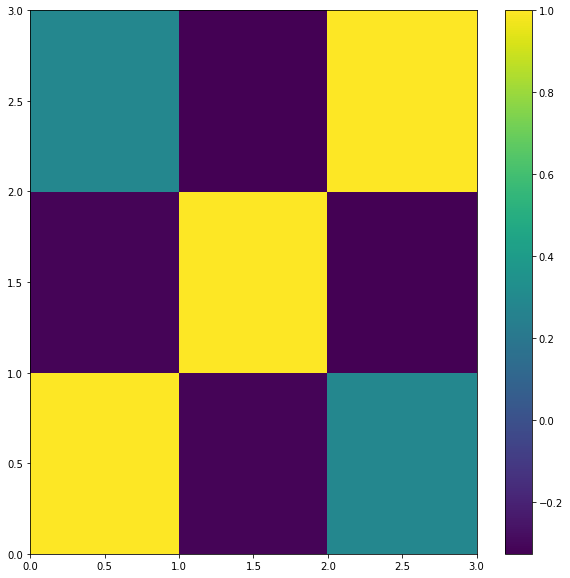

In [482]:
plt.figure(figsize=(10,10))
plt.pcolor(corr_accels)
plt.colorbar()
plt.savefig("corr_flavors.pdf")

In [98]:
new_accels = accels.transpose()
new_accels

,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
x,-0.053802,0.013718,0.145584,-0.099380,0.082794,0.037582,-0.020554,0.032440,0.212524,0.154510,...,0.744705,0.344559,0.519257,0.320328,0.903320,-0.641953,-0.171616,0.401810,0.330338,0.689346
y,-0.987701,-0.852371,-1.007843,-1.209686,-1.001434,-0.998383,-0.999741,-0.970337,-0.976364,-0.843460,...,-2.169205,-0.905853,-1.040115,-0.928375,-1.102219,-1.469177,-0.366074,-1.077698,-1.470062,-0.991043
z,0.068985,-0.000870,-0.036819,0.304489,-0.025375,0.019333,0.120789,0.241425,0.074997,0.010544,...,1.741806,-0.170364,0.262863,0.208405,-0.000549,0.301041,-0.059082,0.258911,0.303894,0.034973


In [97]:
from sklearn.cluster.bicluster import SpectralCoclustering
model = SpectralCoclustering(n_clusters=4, random_state=0)
model.fit(corr_activities)
print(np.sum(model.rows_, axis=1))
print(np.sum(model.rows_, axis=0))
model.row_labels_

[368   2   2   3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,

***Method 1: KNN (k-nearest neighbors)***

In [518]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Import time module
import time
 
# record start time
start = time.time()

TEST_SIZE = 0.5

X = accels['x'].tolist()
Y = accels['y'].tolist()
Z = accels['z'].tolist()

evidence = list()
labels = list()

for i in range(len(X)):
    item = list()
    item.append(X[i])
    item.append(Y[i])
    item.append(Z[i])
    evidence.append(item)

transposed_labels = label_df.transpose()
temp_array = transposed_labels.to_numpy()
for i in range (len(temp_array[0])):
    labels.append(temp_array[0][i])

# Load data from spreadsheet and split into train and test sets
# 10% of data will be used for training, 90% of data will be used for testing
X_train, X_test, y_train, y_test = train_test_split(evidence, labels, test_size=TEST_SIZE)

# Train model and make predictions
# The parameter n_neighbors is the number of neighbors that are taken into account 
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

The time of execution of above program is : 17.000198364257812 ms


In [519]:
print(predictions, len(predictions))

[2 2 2 3 2 3 2 2 3 1 1 2 2 2 2 1 2 2 2 2 1 3 2 2 2 2 2 3 2 2 2 2 1 3 2 1 2
 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 3 3 2 2
 1 2 2 3 3 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 2 2 3 2 2 1 4 1 2 2 2 4 2 2 2 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 2 1] 188


In [520]:
print(y_test, len(y_test))

[3, 2, 2, 1, 2, 2, 2, 4, 2, 1, 1, 3, 2, 2, 4, 1, 1, 3, 3, 2, 1, 3, 3, 2, 4, 2, 2, 4, 2, 2, 3, 4, 1, 1, 2, 1, 2, 1, 2, 2, 4, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 3, 3, 2, 4, 3, 2, 2, 2, 3, 2, 4, 3, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 4, 2, 2, 3, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 1, 3, 2, 2, 2, 2, 1, 4, 1, 2, 2, 4, 3, 4, 4, 4, 3, 4, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 4, 2, 2, 2, 3, 4, 3, 4, 2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 3, 1, 3, 2, 2, 2, 3, 3, 2, 2, 2, 1, 3, 2, 3, 2, 4, 4, 3, 1] 188


In [521]:
# Test the accuracy of the model
counter = 0
for i in range (len(y_test)):
    if predictions[i] == y_test[i]:
        counter += 1
counter/len(y_test)

0.6276595744680851

In [522]:
# A shortcut to testing the accuracy
acc = accuracy_score(y_test, predictions)
acc

0.6276595744680851

***Method 2: Multimodal Logistic Regression***

In [483]:
# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(evidence, labels, test_size=0.5)

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.563 (0.036)


In [484]:
# make a prediction with a multinomial logistic regression model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# define a single row of input data
row = X_test[0]

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model on the whole dataset
model.fit(X_train, y_train)

# predict the class label
yhat = model.predict([row])

# summarize the predicted class
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


In [485]:
# predict probabilities with a multinomial logistic regression model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model on the whole dataset
model.fit(X_train, y_train) 

# define a single row of input data
row = X_test[2]

# predict a multinomial probability distribution
yhat = model.predict_proba([row])

# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat[0])

Predicted Probabilities: [0.0639326  0.4549198  0.27823046 0.20291715]


In [489]:
# record start time
start = time.time()

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model on the whole dataset
model.fit(X_train, y_train)

log_predictions = model.predict(X_test)
print(log_predictions, len(log_predictions))

# record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

[2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 2 3 2 2 2 2 2 3 2 3 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3
 2 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2] 188
The time of execution of above program is : 23.001670837402344 ms


In [487]:
print(y_test, len(y_test))

[2, 2, 2, 1, 2, 4, 3, 2, 3, 2, 4, 3, 2, 3, 3, 2, 4, 3, 2, 3, 3, 2, 3, 2, 4, 2, 2, 3, 2, 3, 2, 2, 2, 4, 4, 3, 1, 1, 1, 2, 4, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 4, 4, 3, 2, 2, 2, 2, 4, 2, 2, 1, 3, 3, 3, 3, 2, 3, 4, 2, 2, 2, 2, 3, 2, 1, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 3, 2, 2, 2, 4, 2, 3, 3, 2, 2, 4, 2, 3, 2, 2, 3, 3, 4, 3, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 3, 2, 4] 188


In [488]:
# Test the accuracy
acc = accuracy_score(y_test, predictions)
acc

0.46808510638297873

***Method 3: Random Forest***

In [490]:
# Create random forest classifier

# record start time
start = time.time()

clf=RandomForestClassifier()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

# Print accuracy with training dataset - should be very close to 1
print (clf.score(X_train, y_train))

# Print accuracy with testing dataset
print(clf.score(X_test, y_test))

# record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

0.9893048128342246
0.5585106382978723
The time of execution of above program is : 29.994964599609375 ms


In [470]:
# Print confusion matrix
# Rows = predicted
# Columns = Actual
# Numbers on diagonal thus tell us how many were correctly classified
from sklearn import tree, model_selection, metrics
metrics.confusion_matrix(y_test, preds,  labels = [1, 2, 3, 4])

array([[ 6,  8,  1,  1],
       [ 4, 82, 13, 12],
       [ 0, 30,  7,  4],
       [ 0, 15,  1,  4]], dtype=int64)

***Best method: KNN***

In [493]:
# Load and read training csv file
fileR = pd.read_csv("test_time_series.csv")
dfR = fileR[['timestamp', 'x', 'y', 'z']].copy()
dfR.head()

,timestamp,x,y,z
0,1565110306139,0.034286,-1.504456,0.157623
1,1565110306239,0.409164,-1.038544,0.030975
2,1565110306340,-0.234390,-0.984558,0.124771
3,1565110306440,0.251114,-0.787003,0.054810
4,1565110306540,0.109924,-0.169510,0.235550


In [494]:
# Take all the rows and just extract the x, y, and z accels
# Call it accels
accelsR = dfR.iloc[:, 1:5]
print(accelsR.head())
print(accelsR.tail())

          x         y         z
0  0.034286 -1.504456  0.157623
1  0.409164 -1.038544  0.030975
2 -0.234390 -0.984558  0.124771
3  0.251114 -0.787003  0.054810
4  0.109924 -0.169510  0.235550
             x         y         z
1245  0.036499 -0.724823  0.553802
1246 -0.159241  0.307022  0.142410
1247 -0.037964 -0.673706  1.065445
1248  0.255707 -1.485397 -0.013336
1249 -0.089462 -0.734573 -0.100876


In [525]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Import time module
import time
 
# record start time
start = time.time()

XR = accelsR['x'].tolist()
YR = accelsR['y'].tolist()
ZR = accelsR['z'].tolist()

evidenceR = list()

for i in range(len(XR)):
    item = list()
    item.append(XR[i])
    item.append(YR[i])
    item.append(ZR[i])
    evidenceR.append(item)

# Train model with all training data now (no need to split) and make predictions
# The parameter n_neighbors is the number of neighbors that are taken into account 
modelR = KNeighborsClassifier(n_neighbors=7)
modelR.fit(evidence, labels)
predictionsR = model.predict(evidenceR)

# Pring real predictions
print(predictionsR)

# record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

[4 2 3 ... 2 2 2]
The time of execution of above program is : 76.00665092468262 ms
